In [100]:
from racetrack import *

In [2]:
from tqdm import tqdm


def index_to_action(i):
    actions = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1), ( 0, 0), ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1),
    ])
    
    return actions[i]


class QLearning:
    def __init__(self, epsilon, step_size, racetrack):
        track_height, track_width, x_vels, y_vels = racetrack.state_space
        x_actions, y_actions = racetrack.action_space
        self.num_actions = x_actions * y_actions
        self.Q = np.zeros((
            track_height,
            track_width,
            x_vels,
            y_vels,
            self.num_actions,
        ))
        self.epsilon = epsilon
        self.step_size = step_size
        self.track = racetrack
        self.ep_lengths = []

    def select_action(self, state, greedy=False):
        x, y, x_vel, y_vel = state
        index = np.argmax(self.Q[x, y, x_vel, y_vel, :])
        if not greedy and np.random.random() < self.epsilon:
            index = np.random.randint(0, self.num_actions)
        return index

    def train(self, num_episodes=100_000):
        original_epsilon = self.epsilon
        self.track.reset()
        for e in tqdm(range(num_episodes)):
            threshold = 5
            self.epsilon = max(
                original_epsilon,
                0.8 - (e / threshold) * (0.8 - original_epsilon)
            )
            x, y, x_vel, y_vel = self.track.state
            done = False
            ep_length = 0
            while not done:
                ep_length += 1
                index = self.select_action((x, y, x_vel, y_vel))
                action = index_to_action(index)
                (x_, y_, x_vel_, y_vel_), reward, done = self.track.step(action)
                self.Q[x, y, x_vel, y_vel, index] += self.step_size * \
                                            (reward + np.max(self.Q[x_, y_, x_vel_, y_vel_]) - \
                                             self.Q[x, y, x_vel, y_vel, index])
                x, y, x_vel, y_vel = x_, y_, x_vel_, y_vel_
            self.ep_lengths.append(ep_length)

    def play_episode(self):
        episode = []
        x, y, x_vel, y_vel = self.track.reset()
        episode.append((x, y, x_vel, y_vel))
        done = False
        while not done:
            index = self.select_action((x, y, x_vel, y_vel), greedy=True)
            action = index_to_action(index)
            (x, y, x_vel, y_vel), reward, done = self.track.step(action, test=True)
            episode.append((x, y, x_vel, y_vel))

        return episode

In [102]:
import numpy as np

from tqdm import tqdm
from math import inf


class NStepStorage:
    def __init__(self, n, dtype=float):
        self.data = np.zeros(n + 1, dtype=dtype)
        self.n = n
        
    def __getitem__(self, key):
        return self.data[key % (self.n + 1)]

    def __setitem__(self, key, value):
        self.data[key % (self.n + 1)] = value


class NStepExpectedSarsa:
    def __init__(self, n, epsilon, alpha, racetrack):
        track_height, track_width, x_vels, y_vels = racetrack.state_space
        self.vel_shift = x_vels // 2
        x_actions, y_actions = racetrack.action_space
        self.num_states = track_height * track_width * x_vels * y_vels
        self.num_actions = x_actions * y_actions
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.n = n
        self.epsilon = epsilon
        self.original_epsilon = epsilon
        self.alpha = alpha
        self.original_alpha = alpha
        self.track = racetrack
        self.ep_lengths = []

    def s_to_idx(self, s):
        x, y, xv, yv = s
        s_ = (x, y, xv + self.vel_shift, yv + self.vel_shift)
        return np.ravel_multi_index(s_, self.track.state_space)


    def index_to_action(self, i):
        actions = np.array([
            (-1, -1), (-1, 0), (-1, 1),
            ( 0, -1), ( 0, 0), ( 0, 1),
            ( 1, -1), ( 1, 0), ( 1, 1),
        ])
        
        return actions[i]

    def exp_Q(self, s):
        Q = (1 - self.epsilon) * np.max(self.Q[s])
        Q += np.sum(self.Q[s]) * (self.epsilon / self.num_actions)
        return Q

    def select_action(self, s, greedy=False):
        a = np.argmax(self.Q[s])
        if not greedy and np.random.random() < self.epsilon:
            a = np.random.randint(0, self.num_actions)
        return a

    def train(self, num_episodes=100_000, quiet=False, target_eps=None, target_alp=None):
        if target_eps is None:
            target_eps = self.original_epsilon
        if target_alp is None:
            target_alp = self.original_alpha
        eps_diff = target_eps - self.original_epsilon
        alp_diff = target_alp - self.original_alpha
        for ep in tqdm(range(num_episodes), disable=quiet):
            states = NStepStorage(self.n, dtype=int)
            actions = NStepStorage(self.n, dtype=int)
            rewards = NStepStorage(self.n)
            states[0] = self.s_to_idx(self.track.reset())
            actions[0] = self.select_action(states[0])
            done = False
            t = 0
            T = inf
            while True:
                t += 1
                if t < T:
                    state, rewards[t], done = self.track.step(self.index_to_action(actions[t-1]))
                    states[t] = self.s_to_idx(state)
                    actions[t] = self.select_action(states[t])
                    if done:
                        T = t
                        self.ep_lengths.append(T)
                tau = t - self.n
                if tau >= 0:
                    ret = sum(rewards[step] for step in range(tau + 1, min(T, t) + 1))
                    if t < T:
                        ret += self.exp_Q(states[t])
                    self.Q[states[tau], actions[tau]] += self.alpha * (ret - self.Q[states[tau], actions[tau]])
                if tau == T - 1:
                    break
            self.epsilon = self.original_epsilon + min(1, (ep / num_episodes)) * eps_diff
            self.alpha = self.original_alpha + min(1, (ep / num_episodes)) * alp_diff

    def play_episode(self, max_steps=-1):
        episode = []
        state = self.track.reset()
        episode.append(state)
        done = False
        steps = 0
        while not done and steps != max_steps:
            steps += 1
            index = self.select_action(self.s_to_idx(state), greedy=True)
            action = index_to_action(index)
            state, reward, done = self.track.step(action, test=True)
            episode.append(state)

        return episode

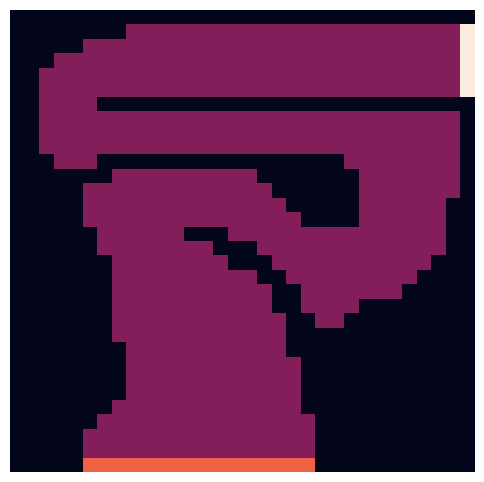

In [103]:
n = 2
epsilon = 0
alpha = 0.5
racetrack = RaceTrack(track_impossible)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(racetrack.track, ax=ax, cbar=False)
ax.axis('off')
plt.show()
agent = NStepExpectedSarsa(n, epsilon, alpha, racetrack)

In [106]:
agent.train(1)

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.17s/it]


In [ ]:
episode = agent.play_episode(max_steps=100)
print("Episode finished! Rendering animation...")
racetrack.render_episode(episode)
Image(url='episode_heatmap_playground.gif')

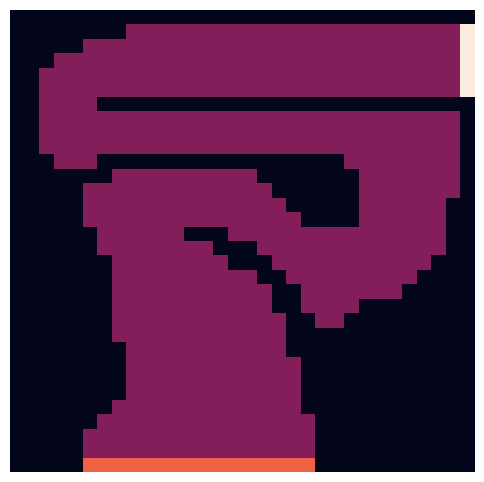

Process number 2 finished!
Process number 1 finished!
Process number 3 finished!


In [114]:
from multiprocessing import Pool, Pipe


def evaluate(argtup):
    conn, epsilon, alpha, n, i, j, k, num_episodes, num = argtup
    total_steps = 0
    for run in range(num_runs):
        agent = NStepExpectedSarsa(n=n, epsilon=0.0, alpha=0.5, racetrack=racetrack)
        agent.train(num_episodes, quiet=True, target_eps=epsilon, target_alp=alpha)
        total_steps += agent.ep_lengths[-1]
    print(f"Process number {num} finished!")
    conn.send(((i, j, k), total_steps / num_runs))
    conn.close()

# Parameters to be sweeped
#epsilons = [0, 0.1, 0.25, 0.5]
#alphas = [0.25, 0.375, 0.5, 0.625, 0.75]
epsilons = [0]
alphas = [0.375, 0.5, 0.625]
ns = [2]
num_runs = 1
num_episodes = 3

# Set up track
racetrack = RaceTrack(track_impossible)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(racetrack.track, ax=ax, cbar=False)
ax.axis('off')
plt.show()

procs = []
pipes = []
argsets = []
proc_num = 0
for i, epsilon in enumerate(epsilons):
    for j, alpha in enumerate(alphas):
        for k, n in enumerate(ns):
            proc_num += 1
            pc, cc = Pipe()
            argsets.append((cc, epsilon, alpha, n, i, j, k, num_episodes, proc_num))
            pipes.append(pc)

with Pool(20) as p:
    p.map(evaluate, argsets)

lengths = np.zeros((len(epsilons), len(alphas), len(ns)))
for pipe in pipes:
    index, value = pipe.recv()
    lengths[index] = value

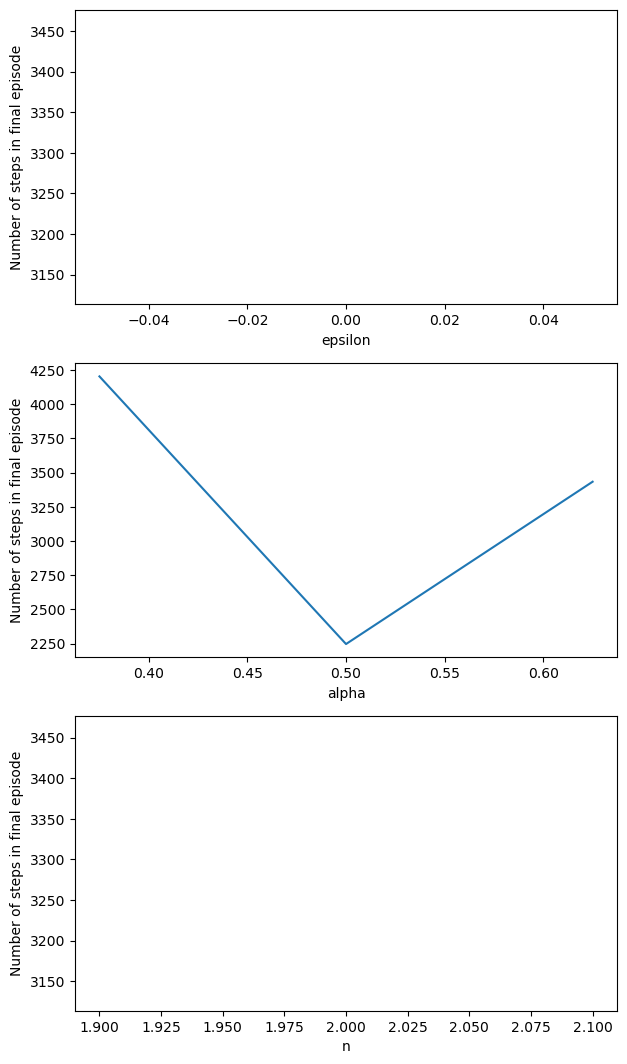

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 13))
epsilon_lengths = np.average(np.average(lengths, axis=1), axis=1)
ax1.plot(epsilons, epsilon_lengths)
ax1.set_xlabel("epsilon")
ax1.set_ylabel("Number of steps in final episode")
alpha_lengths = np.average(np.average(lengths, axis=0), axis=1)
ax2.plot(alphas, alpha_lengths)
ax2.set_xlabel("alpha")
ax2.set_ylabel("Number of steps in final episode")
n_lengths = np.average(np.average(lengths, axis=0), axis=0)
ax3.plot(ns, n_lengths)
ax3.set_xlabel("n")
ax3.set_ylabel("Number of steps in final episode")
plt.show()